# NOTES

# IMPORTS

In [1]:
from keras import layers
from keras import models
from keras.optimizers import SGD
from keras import backend as K
from keras.datasets import cifar10
from keras.callbacks import LearningRateScheduler
from keras.callbacks import BaseLogger
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import json
import os
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


# DATASET

## Variables

In [2]:
lb = LabelBinarizer()
(train_samples, train_labels), (test_samples, test_labels) = cifar10.load_data()

## Data

In [3]:
# Normalization
train_samples = train_samples.astype('float') / 255.0
test_samples = test_samples.astype('float') / 255.0
print(train_samples.shape)
print(test_samples.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Labels

In [4]:
# Binarization
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)
print(train_labels.shape)
print(test_labels.shape)

(50000, 10)
(10000, 10)


## Splitting

In [5]:
(trainX, validationX, trainY, validationY) = train_test_split(train_samples, train_labels, test_size=0.30)
(validationX, predX, validationY, predY) = train_test_split(validationX, validationY, test_size=0.3333)
print('TrainX shape: ',train_samples.shape)
print('ValidationX shape:', validationX.shape)
print('PredictionX shape:', predX.shape)

TrainX shape:  (50000, 32, 32, 3)
ValidationX shape: (10000, 32, 32, 3)
PredictionX shape: (5000, 32, 32, 3)


# ARCHITECTURE

In [6]:
# Network Variables
width = 32
height = 32
depth = 3
filter_01 = 32
filter_02 = 64
pool_size = (2, 2)
conv_stride = (3, 3)
pad = 'same'
classes = 10
input_shape = (width, height, depth)
channels_dim = -1

# Configure input shape
if K.image_data_format() == 'channels_first':
    input_shape = (depth, width, height)
    channels_dim = 1

# Architecture
model = models.Sequential()
model.add(layers.Conv2D(filter_01, conv_stride, padding=pad, input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Conv2D(filter_01, conv_stride, padding=pad))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(filter_02, conv_stride, padding=pad))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Conv2D(filter_02, conv_stride, padding=pad))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(classes))
model.add(layers.Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# MODEL VISUALIZATION

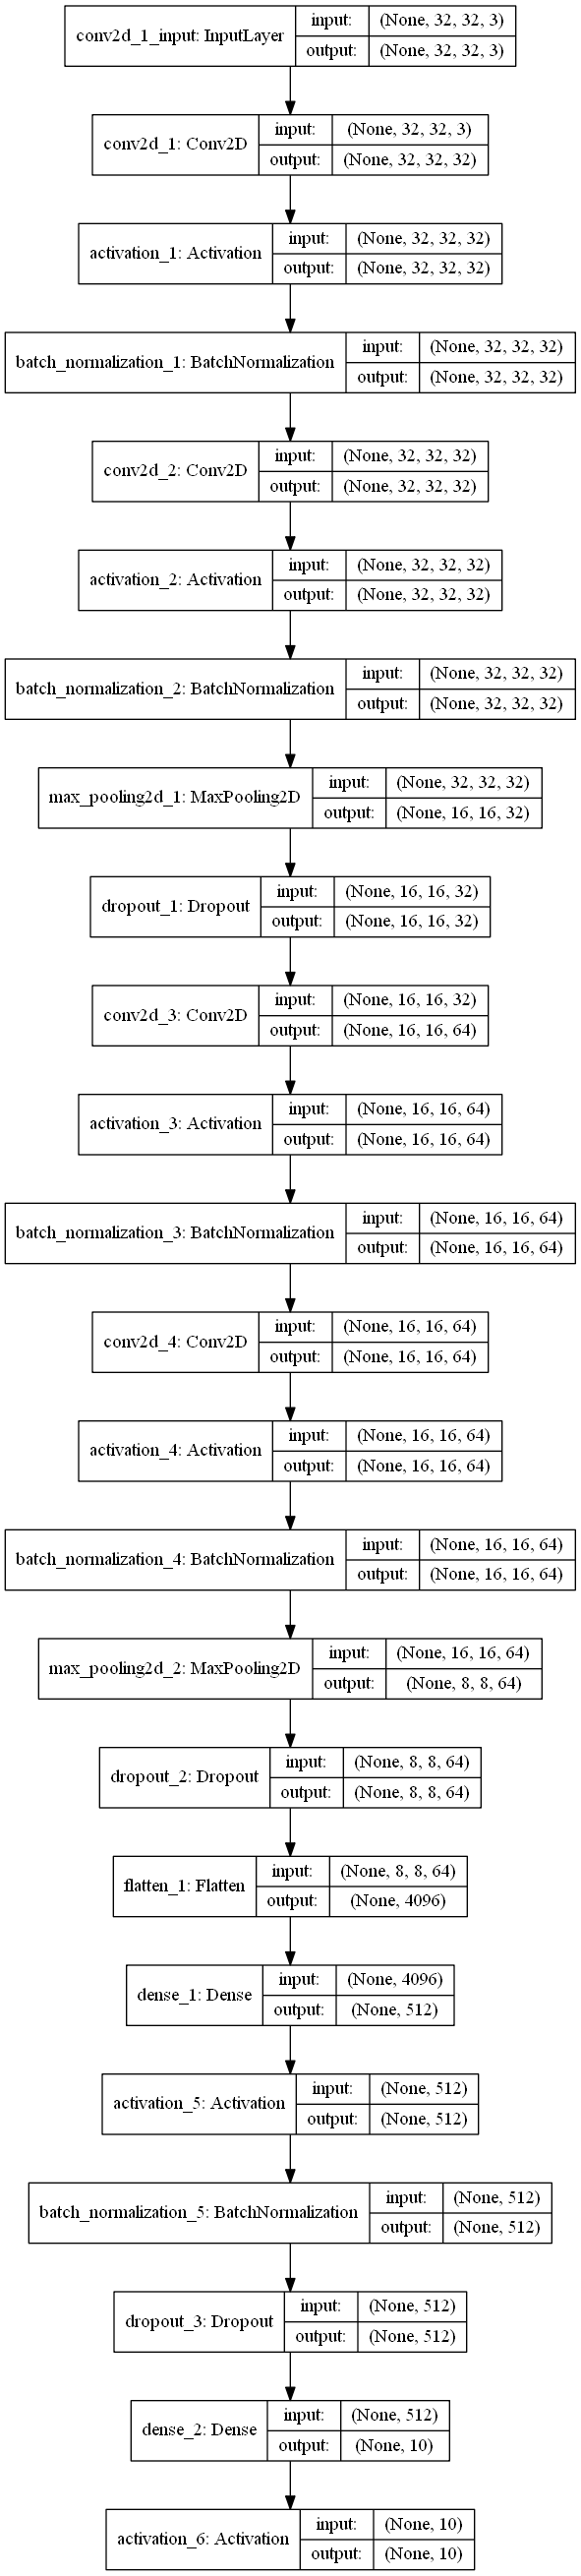

In [7]:
plot_model(model, to_file='Architecture.png', show_shapes=True)

# LEARNING RATE SCHEDULING

## Learning rate

In [8]:
learning_rate = 0.01
epochs = 40

## Step-based Decay

In [9]:
# This function allow us to drop learning rate by factor of (0.25) every five epochs
def step_decay(epoch):
    # Variables
    initAlpha = learning_rate
    factor = 0.5
    dropEvery = 5
    
    # Compute alpha
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    
    return float(alpha)

# COMPILATION

## Variables

In [10]:
# This SDG optimizer make use of time_based weight decay (learning_rate / epochs)
opt_standard = SGD(lr = learning_rate, decay = learning_rate / epochs, momentum=0.9, nesterov=True)

# This optimizer is to be used when you implement a step decay callback. Learning rate is implicitly defined inside callback
opt_step_decay = SGD(momentum=0.9, nesterov=True)

# Normal optimizer
opt_kapa = SGD(lr=learning_rate, momentum=0.9, nesterov=True)

In [11]:
print('[INFO] compiling...')
model.compile(optimizer=opt_kapa, loss='categorical_crossentropy', metrics=['acc'])
print('[INFO] completed.')

[INFO] compiling...
[INFO] completed.


# MONITORING THE TRAIN PROCESS

In [12]:
# Monitoring is accomplished via a TrainMonitor callback whcih is to be called at the end of every epoch
# This class will extend keras' BaseLogger class, since we are working with log files.
class TrainMonitor(BaseLogger):
    # Constructor
    def __init__(self, figPath, jsonPath=None, startAt=0):
        super(TrainMonitor, self).__init__()
        self.figPath = figPath
        self.jsonPath = jsonPath
        self.startAt = startAt
    
    # On train begin callback
    # logs parameter is automatically supplied  
    def on_train_begin(self, logs={}):
        # Initialize the history dictionanry
        self.history_dict = {}
        
        # if the json history path exists, load the training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.history_dict = json.loads(open(self.jsonPath).read())
                
                # Check to see if a starting epoch was supplied
                if startAt > 0:
                    # Loop over the entries in the history log and trim any entries that are past the starting epoch
                    for k in self.History_dict.keys():
                        self.history_dict[k] = self.history_dict[k][:self.startAt]
    
    # This method is called when a training epoch completes
    def on_epoch_end(self, epoch, logs={}):
        # Loop over the log and update the loss, accuracy, etc for the entire training process
        for(k, v)  in logs.items():
            l = self.history_dict.get(k, [])
            l.append(v)
            self.history_dict[k] = l
        
        # Check to see if the training hsitory should be serialized to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, 'w')
            f.write(json.dumps(self.history_dict))
            f.close()
            
        # Plotting, start at epoch 2 and above (epoch, starts at zero)
        if len(self.history_dict['loss']) > 1:
            N = np.arange(0, len(self.history_dict['loss']))
            plt.style.use('ggplot')
            plt.figure()
            plt.plot(N, self.history_dict['loss'], label='Train loss')
            plt.plot(N, self.history_dict['val_loss'], label='Validation loss')
            plt.plot(N, self.history_dict['acc'], label='Train accuracy')
            plt.plot(N, self.history_dict['val_acc'], label='Validation accuracy')
            plt.title('Training Loss and Accuracy [Epoch {}]'.format(len(self.history_dict['loss'])))
            plt.xlabel('Epoch #')
            plt.ylabel('Loss/Accuracy')
            plt.legend()
            plt.savefig(self.figPath)
            plt.close()

In [13]:
print('[INFO] process ID: {}'.format(os.getpid()))

[INFO] process ID: 7492


# TRAINING

## Variables

In [14]:
output_path = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Computer Vision/imagelab/nn/conv/jupyiter/miniVGGNET/Serialized/'
figPath = os.path.sep.join([output_path, '{}.png'.format(os.getpid())])
jsonPath = None #os.path.sep.join([output_path, '{}.json'.format(os.getpid())])
file_name = os.path.sep.join([output_path, 'weights-{epoch:03d}-{val_loss:.4f}.hdf5'])

## Callbacks

In [15]:
# Checkpoint callback
checkpoint = ModelCheckpoint('best_weights.hdf5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [16]:
# Register Callbacks
callbacks = [TrainMonitor(figPath, jsonPath=jsonPath), checkpoint]
# callbacks = [LearningRateScheduler(step_decay)]

# Train
history = model.fit(trainX, trainY, epochs=epochs, batch_size=64, callbacks=callbacks, validation_data=(validationX, validationY))

Train on 35000 samples, validate on 10000 samples
Epoch 1/40
35000/35000 [==============================] - 75s 2ms/step - loss: 1.5932 - acc: 0.4551 - val_loss: 1.3642 - val_acc: 0.5328

Epoch 00001: val_loss improved from inf to 1.36421, saving model to best_weights.hdf5
Epoch 2/40
35000/35000 [==============================] - 66s 2ms/step - loss: 1.1479 - acc: 0.5978 - val_loss: 0.9710 - val_acc: 0.6513

Epoch 00002: val_loss improved from 1.36421 to 0.97098, saving model to best_weights.hdf5
Epoch 3/40
35000/35000 [==============================] - 65s 2ms/step - loss: 0.9667 - acc: 0.6608 - val_loss: 1.2084 - val_acc: 0.5968

Epoch 00003: val_loss did not improve from 0.97098
Epoch 4/40
35000/35000 [==============================] - 63s 2ms/step - loss: 0.8435 - acc: 0.7073 - val_loss: 0.8027 - val_acc: 0.7191

Epoch 00004: val_loss improved from 0.97098 to 0.80272, saving model to best_weights.hdf5
Epoch 5/40
35000/35000 [==============================] - 65s 2ms/step - loss: 0.

# PLOTTING TRAIN RESULT

## Variables

In [19]:
history_dict = history.history
epochs = np.arange(0, 40)

accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.style.use('ggplot')

## Accuracy

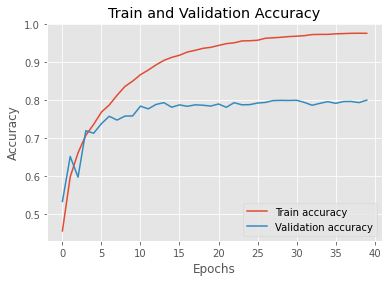

In [20]:
plt.plot(epochs, accuracy, label='Train accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss

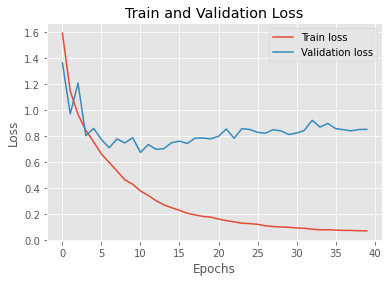

In [21]:
plt.clf()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION

In [22]:
results = model.evaluate(test_samples, test_labels)
results

10000/10000 [==============================] - 11s 1ms/step


[0.8703525933265686, 0.7983999848365784]

# PREDICTION

In [23]:
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predictions = model.predict(predX, batch_size=64)
print(classification_report(predY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

    airplane       0.86      0.83      0.84       503
  automobile       0.90      0.90      0.90       494
        bird       0.69      0.70      0.70       496
         cat       0.66      0.60      0.63       519
        deer       0.74      0.78      0.76       509
         dog       0.64      0.71      0.67       493
        frog       0.85      0.83      0.84       491
       horse       0.83      0.85      0.84       475
        ship       0.93      0.89      0.91       502
       truck       0.89      0.88      0.88       518

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



# CONCLUSION